<a href="https://colab.research.google.com/github/TurgutOzkan/DataSciencity/blob/master/Cost_Sensitive_Prediction_in_Food_Delivery_Business.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The food Delivery business is getting increasingly popular for almost all age groups. Ordering food from the comfort of your home is a big benefit for many. From the business perspective, this also brings challenges. For example, order lateness (underprediction) of delivery time is generally negatively affecting consumer experience. Over-prediction is also problematic but it is usually the case that order lateness is a bigger problem than order earliness. In this exercise, we will assume that underestimating the delivery time is roughly twice as costly as overestimating it. Therefore, we will build a model to predict the estimated time taken for delivery by considering the business challenges in our loss functions. We will work on simulated data and some rounding operations have been done on some features. Due to these operations, total price, total items, minimum and maximum prices need not add up (and others too). Here are the features:


***market***: The market the delivery company operates in. It can be seen as cities in which the company does its deliveries. \
***time:*** Order time. \
***delivery_time:*** The time items delivered. \
***store:*** Stores that are preparing orders. \
***venue_type:*** Cuisine type (American, Mexican etc.) \
***total_items:*** Number of total items in the order. \
***total:*** Total price of the order in dollars. \
***nu_item_purchased:*** The number of distinct items in the order.  \
***min_item_price:*** Minimum price of the item among the order. This is rounded to nearest integer. \
***max_item_price:*** Max price of the item among the order.  \
***total_delivery_person***: Total number of delivery people active in the area. \
***total_busy_delivery_person:*** Total number of delivery people that are busy delivering other items. \
***order_duration:*** Estimated duration for placing the order by the delivery provider.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None
df = pd.read_csv("simulated_delivery_data.csv")
print(df.shape)

(39484, 13)


In [15]:
df.head(3)

,market,time,delivery_time,store,venue_type,total_items,total,nu_item_purchased,min_item_price,max_item_price,total_delivery_person,total_busy_delivery_person,order_duration
0,2.0,2016-01-25 02:55:36,2016-01-25 03:29:48,8531,pizza,3,36.0,3,12.0,12.0,60.0,60.0,281
1,6.0,2016-02-10 22:03:21,2016-02-10 22:43:09,4973,burger,6,30.0,4,3.0,9.0,21.0,10.0,476
2,12.0,2016-01-25 02:21:46,2016-01-25 04:59:10,3367,pizza,5,64.0,4,5.0,28.0,NaN,NaN,476


We will create the outcome feature as a time span from the order time to delivery time measured in seconds.

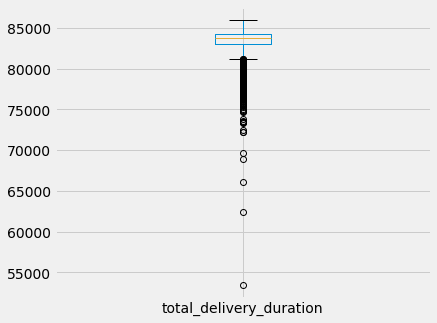

In [16]:
df.time = pd.to_datetime(df.time)
df.delivery_time = pd.to_datetime(df.delivery_time)
df["total_delivery_duration"] = (df['time'] - df['delivery_time']).dt.seconds
# examine the outcome variable
boxplot = df.boxplot(column=['total_delivery_duration'] , figsize=(6,5))

Let's remove some outliers by setting a threshold. With outliers removed, the distribution looked a lot like normal below.

(39067, 14)


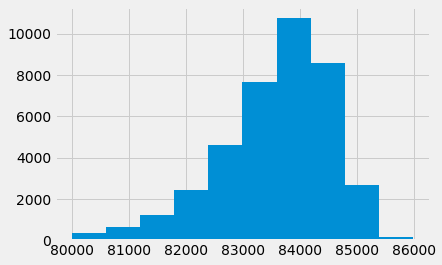

In [17]:
num = 80000
df = df[df["total_delivery_duration"]>num]
print(df.shape)
df.total_delivery_duration.hist()

**Exploratory Data Analysis**

In [18]:
df.dtypes

market                               float64
time                          datetime64[ns]
delivery_time                 datetime64[ns]
store                                  int64
venue_type                            object
total_items                            int64
total                                float64
nu_item_purchased                      int64
min_item_price                       float64
max_item_price                       float64
total_delivery_person                float64
total_busy_delivery_person           float64
order_duration                         int64
total_delivery_duration                int64
dtype: object

Let's create features indicating the day of the week and hour of the day. Then, we check if we have missing data.

In [19]:
def create_service_day(dataset, datecolumn):
    """returns day name for a given date column.
    Column should be datetime object"""
    return dataset[datecolumn].dt.day_name() 

def create_service_hour(dataset, datecolumn):
    """returns hour name for a given date column.
    Column should be datetime object"""
    return dataset[datecolumn].dt.hour

df['order_day'] = create_service_day(df, 'time')
df['order_hour'] = create_service_hour(df, 'time')

In [20]:
df.isnull().sum()

market                         204
time                             0
delivery_time                    0
store                            0
venue_type                    1006
total_items                      0
total                            0
nu_item_purchased                0
min_item_price                   0
max_item_price                   0
total_delivery_person         3225
total_busy_delivery_person    3225
order_duration                   0
total_delivery_duration          0
order_day                        0
order_hour                       0
dtype: int64

We have some missing data and we will deal with them later. Now, we will visually examine certain features. First, we plot order frequency by order hours.

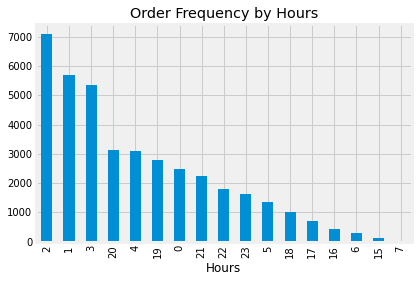

In [9]:
df['order_hour'].value_counts().plot(kind='bar')
plt.title('Order Frequency by Hours')
plt.xlabel('Hours')
plt.show()

It seems like 2 am and 1 am have the most order frequency in our data. Remember this is simulated data (with serious noise) and it may be at odds with reality. With cleaner data, you would have a better insight following the same procedure. Anyways, let's see how orders play out with the day of the week!

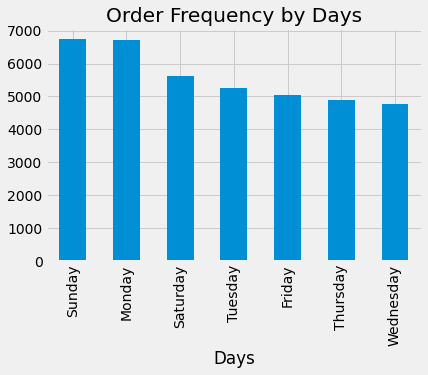

In [13]:
df['order_day'].value_counts().plot(kind='bar',title='Order Frequency by Days')
plt.xlabel('Days')
plt.show()

It looks like Sunday and Monday are the busy days. We can further analyze other features but we will leave it here. Now, we will create Train, Validation and Test Sets.

In [21]:
ratios = [0.7, 0.85]
def create_train_val_test(dataset, ratios):
    """
    Takes a dataframe and split ratios, then return 
    train, validation, and test sets. Divides data into
    three sets defined by ratios. For example, 
    ratios = [0.7, 0.85] would create
    70% train set, 15% validation set, and 15% test set.
    
        Parameters:
                dataset (dataframe): pandas dataframe
                ratios (list): first threshold defines train
                portion, and from that to the second threshold
                is validation, and the rest is test set. Since
                data is shuffled, these are purely random sets.

        Returns:
                train, validation, and test sets for both 
                X and y (dataframe): pandas dataframe
    """
    
    # Add unique id to facilitate checking the randomness
    dataset['id'] = range(1, 1 + len(dataset))
    # shuffle data from creating random sets
    dataset = dataset.sample(frac=1, random_state=3)
    # create train, validation, and test sets
    df_train = dataset.iloc[0: round(ratios[0] * len(dataset)), :]
    df_val = dataset.iloc[round(ratios[0] * len(dataset)): round(ratios[1] * len(dataset)), :]
    df_test = dataset.iloc[round(ratios[1] * len(dataset)): , :]
    # sanity check
    assert set() == set(df_train.id) & set(df_val.id) & set(df_test.id)
    # drop ids
    df_train.drop(columns=['id'], inplace=True)
    df_val.drop(columns=['id'], inplace=True)
    df_test.drop(columns=['id'], inplace=True)
    print("Train size:", df_train.shape)
    print("Validation size:", df_val.shape)
    print("Test size:", df_test.shape )
    return df_train, df_val, df_test

df_train, df_val, df_test = create_train_val_test(df, ratios)

Train size: (27347, 16)
Validation size: (5860, 16)
Test size: (5860, 16)


On-time delivery is a function of three things. Order placement by app (internal system of the delivery company), store food prep time, and finally, the delivery person actually delivering the items. Let's generate a new feature, that shows the ratio between total_busy_delivery_person and total_delivery_person and call this feature a serviceability score. If serviceability is 1, that means all delivery folks are busy with orders at hand, whereas 0 means, all of them are idle now.

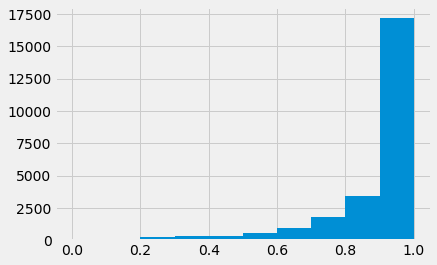

In [22]:
def servicability_score(dataset):
    """
    calculates the ratio between total_busy_delivery_person
    and total_delivery_person.
    """
    dataset['servicability'] = dataset.total_busy_delivery_person / dataset.total_delivery_person
    dataset.loc[dataset.total_busy_delivery_person > dataset.total_delivery_person, 'servicability'] = 1
    dataset.loc[(dataset.total_busy_delivery_person ==0) & (dataset.total_delivery_person==0), 'servicability'] = 1
    dataset.loc[dataset.servicability < 0, 'servicability'] = round(dataset.servicability.median(),2)
    return dataset

df_train = servicability_score(df_train)
# let's see servicability distribution
df_train.servicability.hist()

Earlier, we detected some missingness in our data. We will impute the data below. We will focus on mode and median imputation. Mode imputation is good for categorical values and median is good whenever you have a continuous value that may have serious outliers.

In [23]:
from sklearn.impute import SimpleImputer

def mode_imputer_fit(dataset, column_list):
    """
    Takes a dataframe and a list of columns
    to fit an imputer with the most frequent value
    
        Parameters:
                dataset (dataframe): Pandas dataframe
                column_list (list) : Python list

        Returns:
                fitted SimpleImputer Scikitlearn Object
    """
    imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imp_mode.fit(dataset[column_list])
    return imp_mode

def mode_imputer_transform(dataset, column_list, imputerObject):
    """
    Takes a dataframe and a list of columns
    and impute with the most frequent value
    
        Parameters:
                dataset (dataframe): Pandas dataframe
                column_list (list) : Python list
                imputerObject (object): SimpleImputer Scikitlearn Object

        Returns:
                dataframe consists of imputed column_list
    """
    dataset[column_list] = imp_mode.transform(dataset[column_list])
    return dataset[column_list]

cols_to_mode_impute = ['market', 'venue_type']
imp_mode = mode_imputer_fit(df_train, cols_to_mode_impute)
df_train[cols_to_mode_impute] = mode_imputer_transform(df_train, cols_to_mode_impute, imp_mode)

def median_imputer_fit(dataset, column_list):
    """
    Takes a dataframe and a list of columns
    to fit an imputer with the median value
    
        Parameters:
                dataset (dataframe): Pandas dataframe
                column_list (list) : Python list

        Returns:
                fitted SimpleImputer Scikitlearn Object
    """
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_median.fit(dataset[column_list])
    return imp_median

def median_imputer_transform(dataset, column_list, imputerObject):
    """
    Takes a dataframe and a list of columns
    and impute with the median value
    
        Parameters:
                dataset (dataframe): Pandas dataframe
                column_list (list) : Python list
                imputerObject (object): SimpleImputer Scikitlearn Object

        Returns:
                dataframe consists of imputed column_list
    """
    dataset[column_list] = imp_median.transform(dataset[column_list])
    return dataset[column_list]

cols_to_median_impute = ['total_delivery_person', 'total_busy_delivery_person']
imp_median = median_imputer_fit(df_train, cols_to_median_impute)
df_train[cols_to_median_impute] = median_imputer_transform(df_train, cols_to_median_impute, imp_median)

We resorted to simply converting stores into their frequencies. This makes sense as stores that have high traffic will be represented as such. These numbers also give insights about the location demographics too since presumably more delivery persons operate in more crowded locations.

In [24]:
# convert store_into numerical values
store_dict = df_train.store.value_counts(dropna=False).to_dict()
df_train.store = df_train.store.map(store_dict)

Now, we will use a different kind of encoding for didactic purposes. Target encoding is an alternative encoding which works well whenever you have high cardinality. Particularly, we will encode venue_type and order_hour with target encoding. you can pip install category_encoders to install it if you do not have it on your machine.

In [26]:
#!pip install category_encoders

     |████████████████████████████████| 81kB 4.1MB/s 


In [27]:
from category_encoders import TargetEncoder

# save encoders in a dictionary
encoders_list = {}
def fit_target_encoder(dataset, col, outcome, num):
    """
    fits target encoder on a column based on a smoothing
    parameter
    
         dataset (dataframe): dataframe
         col (series): column to target encode
         outcome (series): target feature
         num (integer): smoothing paremeter to control
         overfitting
    """
    encoder = TargetEncoder(smoothing=num)
    return encoder.fit(dataset[col].astype("category"),  dataset[outcome])

# fit target encoding on venue_type and order_hour
venue_type_encoder = fit_target_encoder(
    df_train,'venue_type','total_delivery_duration', 500
)
order_hour_encoder = fit_target_encoder(
    df_train,'order_hour','total_delivery_duration', 5000
)

# add encoded features as new features
df_train['venue_type_encoded'] = venue_type_encoder.transform(
    df_train['venue_type']
)

df_train['order_hour_encoded'] = order_hour_encoder.transform(df_train['order_hour'])

# let's check how the encoding worked
df_train[['venue_type','venue_type_encoded', 'order_hour', 'order_hour_encoded']].head(3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,venue_type,venue_type_encoded,order_hour,order_hour_encoded
13903,mediterranean,83641.858074,0,83696.104556
976,convenience-store,83704.836823,20,83718.905928
22032,other,83698.694458,20,83718.905928


As can be seen, venue_type mediterranean is represented with 83641 and thus available for further numeric computations. Below, yet another way of dealing with categories. In this case, binary values. We will simple create dummies and attach those dummies to our original data frame.

In [28]:
def create_dummies(dataset, col):
    """
    converts categories into dummies
    for a given column and dataset.
    Returns a dataframe.
    """
    return pd.get_dummies(dataset[col], prefix=col, drop_first=True)


def attach_dummies(dataset, col):
    """
    combines created dummy dataframes to
    main dataframe. Returns combined dataframe.
    """
    dataset2 = pd.concat([dataset, create_dummies(dataset, col)], axis=1)
    dataset2.drop(columns=[col], inplace=True)
    return dataset2

# add dummy features
dummy_features = ['market', 'order_day']

for column in dummy_features:
    df_train = attach_dummies(df_train, column)
    print(df_train.shape)

(27347, 23)
(27347, 28)


In [29]:
# drop date features and venue_type
df_train.drop(columns=['time', 'delivery_time','order_hour', 'venue_type'], inplace=True)
print(df_train.shape)

(27347, 24)


Next, we will form input data frame (X) and output series as well as examining correlations among our features.

In [30]:
# Create x, y
X_train = df_train.drop(columns=['total_delivery_duration'])
y_train = df_train.total_delivery_duration

# check if any feature have correlation above 0.85
def find_corr(dataset, threshold):
    """ Takes dataframe and prints features
    that are correlated above given threshold"""
    corr_matrix = dataset.corr().abs()
    high_corr_var=np.where(corr_matrix> threshold)
    high_corr_var=[
        (corr_matrix.columns[x],corr_matrix.columns[y]) 
        for x,y in zip(*high_corr_var) if x!=y and x<y
                  ]
    print(high_corr_var)
find_corr(X_train, 0.9)


[('total_delivery_person', 'total_busy_delivery_person')]


In [31]:
# drop highly collinear variables
X_train.drop(columns=['total_delivery_person'], inplace=True)
print(X_train.shape)

(27347, 22)


Let's see how our input dataframe looks at this stage.

In [32]:
X_train.head()

,store,total_items,total,nu_item_purchased,min_item_price,max_item_price,total_busy_delivery_person,order_duration,servicability,venue_type_encoded,order_hour_encoded,market_4.0,market_6.0,market_8.0,market_10.0,market_12.0,order_day_Monday,order_day_Saturday,order_day_Sunday,order_day_Thursday,order_day_Tuesday,order_day_Wednesday
13903,37,2,39.0,1,19.0,20.0,29.0,281,1.000000,83641.858074,83696.104556,0,0,0,0,0,1,0,0,0,0,0
976,1,2,4.0,2,2.0,2.0,39.0,281,0.975000,83704.836823,83718.905928,0,0,0,0,0,0,0,0,0,0,0
22032,3,2,20.0,2,10.0,10.0,80.0,281,0.987654,83698.694458,83718.905928,0,0,1,0,0,0,0,0,0,0,1
35724,9,2,27.0,2,8.0,13.0,8.0,476,0.888889,83432.786268,83807.266849,0,0,0,1,0,0,0,1,0,0,0
17554,3,2,13.0,2,4.0,8.0,48.0,476,1.000000,83610.999430,83309.167286,0,0,0,0,0,0,0,0,1,0,0


Now, we will generate a business metric to monitor. We will not optimize for this specific metric, but we will do somewhat after-the-fact analysis on the result.

Remember, we are more concerned about late deliveries as they incur larger costs on the business. Typically, we will create four segments as below:

*mild underprediction*: underpredicting within 10 minutes. \
*severe underprediction*: underpredicting more than 10 minutes \
*mild overprediction*: overpredicting within 10 minutes. \
*severe overprediction*: overpredicting more 10 than minutes.

In [33]:
def business_metric_eval(y_true, y_pred, acceptance):
    
    """
    In order to monitor underpredicted value prevalence, this function
    groups predictions into four categories:
    
        y_true (array): true values
        y_pred (array): predicted values
        
    prints percentage for each group.
    """
    
    error = y_pred - y_true
    result = pd.DataFrame(zip(y_true.values, y_pred, error),
                     columns=['y_true', 'y_pred', 'error'])
    result.loc[(result.error>0) & (result.error <= acceptance), 'lateness']='mild_overprediction'
    result.loc[result.error > acceptance, 'lateness']= 'severe_overprediction'
    result.loc[(result.error<0) & (result.error >= -acceptance), 'lateness']= 'mild_underprediction'
    result.loc[result.error < -acceptance, 'lateness']= 'severe_underprediction'
    print(result.lateness.value_counts(dropna=False, normalize=True))

**Validation**

Now, we will apply same transformation we did for the train set to the validation and test sets.

In [34]:
cols_to_mode_impute = ['market', 'venue_type']
df_val[cols_to_mode_impute] = mode_imputer_transform(df_val, cols_to_mode_impute, imp_mode)

cols_to_median_impute = ['total_delivery_person', 'total_busy_delivery_person']
df_val[cols_to_median_impute] = median_imputer_transform(df_val, cols_to_median_impute, imp_median)

df_val = servicability_score(df_val)
df_val.store = df_val.store.map(store_dict)
df_val.store = df_val.store.fillna(value=df_val.store.median())
# df_val.store = df_val.store.fillna(value=df_val.median)
df_val['venue_type_encoded'] = venue_type_encoder \
.transform(df_val['venue_type'])

df_val['order_hour_encoded'] = order_hour_encoder.transform(df_val['order_hour'])
    
dummy_features = ['market', 'order_day']

for column in dummy_features:
    df_val = attach_dummies(df_val, column)
    print(df_val.shape)
    
df_val.drop(columns=['time', 'delivery_time','order_hour', 'venue_type', 'total_delivery_person'], inplace=True)
X_val = df_val.drop(columns=['total_delivery_duration'])
#X_val.drop(columns=drop_features, inplace=True)
y_val = df_val.total_delivery_duration
print(X_val.shape)

(5860, 23)
(5860, 28)
(5860, 22)


Test

In [35]:
cols_to_mode_impute = ['market', 'venue_type']
df_test[cols_to_mode_impute] = mode_imputer_transform(df_test, cols_to_mode_impute, imp_mode)

cols_to_median_impute = ['total_delivery_person', 'total_busy_delivery_person']
df_test[cols_to_median_impute] = median_imputer_transform(df_test, cols_to_median_impute, imp_median)

df_test = servicability_score(df_test)
df_test.store = df_test.store.map(store_dict)
df_test.store = df_test.store.fillna(value=df_test.store.median())

df_test['venue_type_encoded'] = venue_type_encoder \
.transform(df_test['venue_type'])

df_test['order_hour_encoded'] = order_hour_encoder \
.transform(df_test['order_hour'])
    
dummy_features = ['market', 'order_day']

for column in dummy_features:
    df_test = attach_dummies(df_test, column)
    print(df_test.shape)
    
df_test.drop(columns=['time', 'delivery_time','order_hour', 'venue_type','total_delivery_person'], inplace=True)
X_test = df_test.drop(columns=['total_delivery_duration'])
#X_test.drop(columns=drop_features, inplace=True)
y_test = df_test.total_delivery_duration
print(X_test.shape)

(5860, 23)
(5860, 28)
(5860, 22)


At this point, we have train, test, and validation datasets ready for modeling. As you recall, we want less underprediction in our model, thus need a cost-sensitive model. There are two ways we can achieve this goal. 

- Using quantile loss function. It allows estimating the conditional quantile of the outcome given certain values of predictor variables. It can be seen as an extension of Mean Absolute Error where the quantile is 50th percentile. by defining a quantile value we can differentially weight positive errors or negative errors.  A good discussion is available [here](https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0). We will use alpha=0.66 for the kind of cost sensitivess we want after specifying our objective function as quantile loss.
- Using custom oss function by penalizing underprediction more heavily.

Next, we will do a hyperparameter tuning using a grid search method with cross-validation.

In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
param_grid = {
    'seed': [3],
    'num_threads':[4],
    'num_leaves': [30, 40],
    'learning_rate': [0,1, 0.2, 0.3, 0.4],
    'n_estimators': [30, 40, 50],
    'reg_lambda' : [0,2, 0.3, 0.4],
    'min_child_samples' : [100, 120],
    'max_depth':[3, 4, 5],
    'early_stopping_rounds': [4, 5],
    'colsample_bytree': [0.9],
    'silent': [True]
}

estimator = lgb.LGBMRegressor(objective='quantile', alpha=0.66)

gbm_q = GridSearchCV(estimator, param_grid, cv=3, verbose=True)
gbm_q.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='quantile'
)

In [ ]:
print(gbm_q.best_estimator_)

LGBMRegressor(alpha=0.66, boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.9, early_stopping_rounds=5,
              importance_type='split', learning_rate=0.4, max_depth=5,
              min_child_samples=120, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=30, num_threads=4,
              objective='quantile', random_state=None, reg_alpha=0.0,
              reg_lambda=2, seed=3, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def report_results(model):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    print("Train MSE:", mean_squared_error(y_train, y_train_pred))
    print("Val MSE:", mean_squared_error(y_val, y_val_pred))
    print("Test MSE:", mean_squared_error(y_test, y_test_pred))
    print()
    print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
    print("Val MAE:", mean_absolute_error(y_val, y_val_pred))
    print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
    return y_train_pred, y_val_pred, y_test_pred

y_train_pred, y_val_pred, y_test_pred = report_results(gbm_q)

Train MSE: 894146.87964411
Val MSE: 904826.9100338337
Test MSE: 901472.3777308738

Train MAE: 673.9962436171836
Val MAE: 693.6950074198556
Test MAE: 697.9164536492077


Results seems ok, and there is no sign of overfitting. Let's check our business metrics too.

In [ ]:
business_metric_eval(y_test, y_test_pred, acceptance=600)

severe_overprediction     0.354608
mild_overprediction       0.305461
mild_underprediction      0.259044
severe_underprediction    0.080887
Name: lateness, dtype: float64


As you see we have overpredicted more than we underpredicted in the data. In fact, 30% of the time we will deliver 10 minutes before the actual time. 35% of the time it will be earlier than 10 minutes (say, you promised to deliver at 5.15pm and the delivery person knocks on your door at 5.00pm). 

Note that we could achieve a similar outcome by defining the asymmetric loss function. Below allows us to integrate cost sensitiveness into our model by two additional functions as outlined below. You can compare the results and pick whichever performs better (quantile loss vs custom loss).

In [ ]:
# # GridSearch Lightgbm with Asymmetric Loss Function
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
# custom function that penalizes underprediction
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual>0, -2* 2 *residual, -2*residual)
    hess = np.where(residual>0, 2* 2, 2.0)
    return grad, hess
# evaluation function that penalizes underprediction
def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual > 0, (residual**2)*2, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

estimator = lgb.LGBMRegressor(objective=custom_asymmetric_objective)


gbm = GridSearchCV(estimator, param_grid, cv=3, verbose=4)
gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=custom_asymmetric_eval
)

In [ ]:
print(gbm.best_estimator_)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
              early_stopping_rounds=4, importance_type='split',
              learning_rate=0.2, max_depth=5, min_child_samples=100,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=30,
              n_jobs=-1, num_leaves=40, num_threads=4,
              objective=<function custom_asymmetric_objective at 0x7fcf2e09ccb0>,
              random_state=None, reg_alpha=0.0, reg_lambda=0, seed=3,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)


In [ ]:
y_train_pred, y_val_pred, y_test_pred = report_results(gbm.best_estimator_) # gbm.best_estimator_

Train MSE: 721169.7183577482
Val MSE: 737275.6008938353
Test MSE: 723120.1144064858

Train MAE: 645.8325039503125
Val MAE: 656.452186621599
Test MAE: 651.9079688295558


In [ ]:
business_metric_eval(y_test, y_test_pred, acceptance=600)

mild_underprediction      0.314164
mild_overprediction       0.241809
severe_overprediction     0.230546
severe_underprediction    0.213481
Name: lateness, dtype: float64


As a result, the custom loss model we defined outperformed the quantile-based loss model in regression metrics (MSE and MAE). But if we check the business metric, the custom-loss model has more undesirable underpredictions. For example, about 44% of the time, the model under predicts with almost half of it being severe underprediction. For the quantile-loss model, we had underpredicted 34% of the time and severe underpredictions were about 8%. If our business case strongly dictates us to focus on fewer underpredictions, then a quantile-based model would be a better choice. 

In conclusion, we have analyzed food delivery business data and discussed some business aspects. Also, we injected business concerns into data science workflow by integrating cost-sensitive predictions. Specifically, we have seen two ways of injecting cost sensitiveness into our tree-based models. Hope you enjoyed it!